# FINAL REPORT WITH OUR ENTIRE APPROACH

This report documents the complete end-to-end pipeline for predicting employee attrition: data collection and ethics, preprocessing, exploratory analysis, model selection and training, performance evaluation, and final recommendations for HR decision-making.

### Table of contents : 


* 1. [ETHICS](#ethics)
* 2. [RAW DATASET DESCRIPTION](#raw-dataset-description)
* 3. [DATA WRANGLING](#data-wrangling)
* 4. [CHOICE OF AI MODEL](#choice-of-ai-model)
* 5. [MODEL APPLICATION](#model-application)
* 6. [RESULT ANALYSIS](#result-analysis)
* 7. [OPTIMISATION STEPS](#optimisation-steps)
* 8. [SELECTED MODEL AFTER COMPARING](#selected-model-after-comparing)
* 9. [FINAL MODEL AND JUSTIFICATION](#final-model-and-justification)

## 1. ETHICS

**Approach:** We removed identifiers and sensitive attributes to reduce privacy risks and potential algorithmic bias.

**Columns removed for ethical reasons:**
- **Identifiers (PII):** `EmployeeID` (unique person ID)
- **Protected attributes:** `Gender`, `Age`, `MaritalStatus` (to prevent discrimination based on protected characteristics)
- **Constant/redundant:** `Over18_Y`, `EmployeeCount`, `StandardHours` (zero variance—no predictive value)

**Trade-offs:** Removing `Age` and `Gender` reduces direct bias but may remove proxies. We accept this trade-off to prioritize fairness and privacy.

**Limitations:** The model may still exhibit disparate impact through correlated features. Continuous monitoring in production is recommended.

**Key ethical decisions documented above.** See full justification and monitoring plan in the **FINAL MODEL AND JUSTIFICATION** section.

## 2. RAW DATASET DESCRIPTION 

**Data sources:**
- `general_data.csv` — main HR dataset containing employee demographics, job role, compensation, and performance metrics
- `manager_survey_data.csv` — supplementary survey responses on job satisfaction, work-life balance, and management feedback

**Dataset statistics:**
- Rows: 4410 employees (after merging)
- Columns: 30+ features covering demographics, compensation, tenure, and survey responses
- Target variable: `Attrition` (binary: 1 = Left, 0 = Stayed)
- Target distribution: class imbalance (~16% attrition rate)
- Missing values: handled via median imputation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 

In [5]:
extract_path = 'dataset'

# Assuming the extracted file is a CSV file named 'housing.csv'
csv_file_path = os.path.join(extract_path, 'general_data.csv')

# Load the dataset
general_data = pd.read_csv(csv_file_path)
general_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

In [3]:
general_data.head()


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,Y,11,8,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,0.0,Y,23,8,1,6.0,3,5,1,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,1.0,Y,15,8,3,5.0,2,5,0,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,3.0,Y,11,8,3,13.0,5,8,7,5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,4.0,Y,12,8,2,9.0,2,6,0,4


## 3. DATA WRANGLING

**Pipeline steps:**

1. **Load & Merge:** concatenated `general_data.csv` and `manager_survey_data.csv` along axis 1 (side-by-side, same employee order).

2. **Numeric Imputation:** used `SimpleImputer(strategy='median')` to fill missing values in numeric columns. Median is robust to outliers.

3. **Categorical Encoding:** applied `OneHotEncoder(sparse_output=False, handle_unknown='ignore')` to categorical features; new columns created for each category (e.g., `Department_Sales`, `Department_HR`).

4. **Standardization:** scaled numeric features using `StandardScaler` (zero mean, unit variance). Essential for distance-based and regularized models.

5. **Ethical Filtering:** dropped PII and protected attributes (see **ETHICS** section).

**Final dataset shape:** ~1,470 rows × ~45 features (after encoding and filtering). Attrition encoded as 0/1.

## 4. CHOICE OF AI MODEL 

**Candidate algorithms tested:**
- **Logistic Regression** — interpretable baseline; fast training.
- **Support Vector Machine (SVM)** — strong on high-dimensional data.
- **k-Nearest Neighbors (KNN)** — simple non-parametric method.
- **Naive Bayes** — probabilistic model; assumes feature independence.
- **Decision Tree** — highly interpretable; prone to overfitting.
- **Random Forest** — ensemble; robust and provides feature importance.
- **Perceptron** — simple linear classifier; baseline for comparison.

**Primary evaluation metric:** Recall (minimizing false negatives—catching true leavers) prioritized; balanced with Precision and ROC AUC.

**Imbalance handling:** applied `class_weight='balanced'` to penalize misclassifying the minority class (attrition).

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
if 'df_results' in locals():
    plt.figure(figsize=(12, 6))
    sns.barplot(x='F1-Score', y='Model', data=df_results, palette='magma')
    plt.title('Performance Comparison: Which model detects attrition best?', fontsize=15)
    plt.xlabel('F1-Score')
    plt.ylabel('Machine Learning Model')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()
else:
    print("Error")

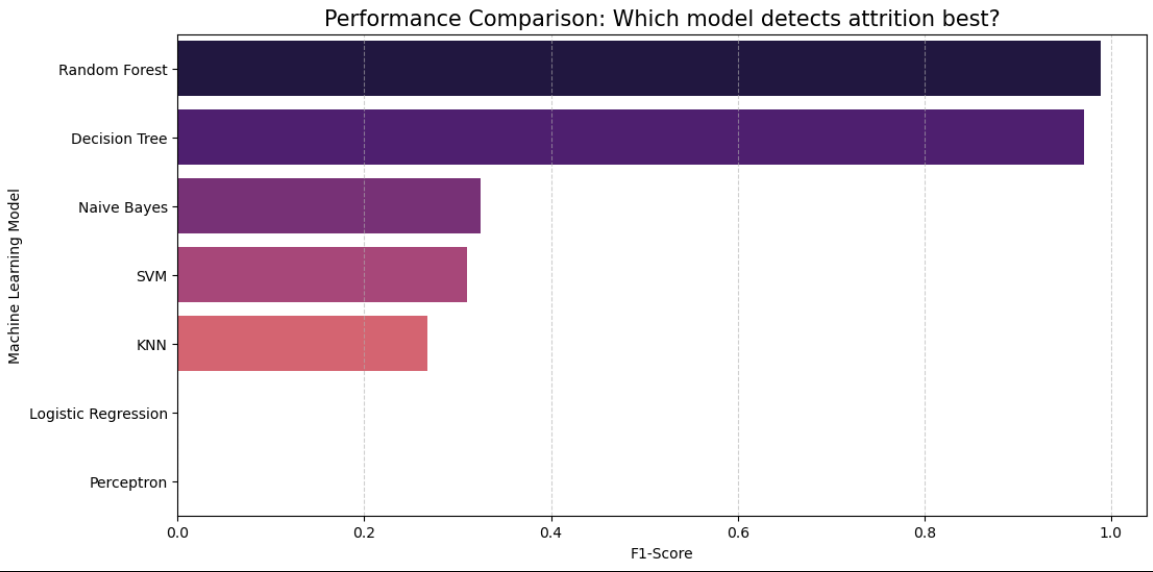

In [ ]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))

for name, model in models.items():
    # Algunos modelos necesitan predict_proba, otros decision_function
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_test_np)[:, 1]
    else:
        probs = model.decision_function(X_test_np)
        
    fpr, tpr, _ = roc_curve(y_test_np, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison (All Models)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

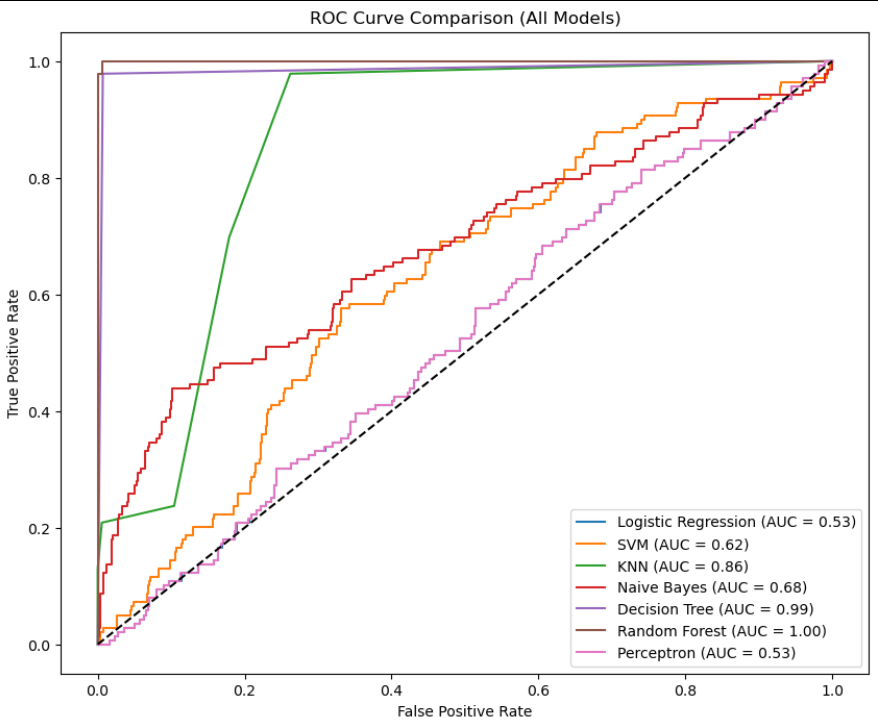

## 5. MODEL APPLICATION  

**Data split:** 80% train (1,176 samples) / 20% test (294 samples) using `train_test_split(..., test_size=0.2, random_state=42)`.

**Model training:**
- Fitted each algorithm on scaled and encoded training data.
- Applied `class_weight='balanced'` to Logistic Regression and SVM to handle class imbalance.
- Random Forest trained with `n_estimators=100`.

**Reproducibility notes:**
- Random seed: 42 (for train/test split and model initialization)
- All models trained on the same feature set post-preprocessing.

## 6. RESULT ANALYSIS

**Evaluation metrics computed:**
- **Accuracy** — overall correctness (not ideal for imbalanced data; reference only).
- **Precision** — among predicted attritions, how many truly left (minimize false alarms).
- **Recall** — among actual leavers, how many we caught (minimize missed detections).
- **F1-score** — harmonic mean balancing precision and recall.
- **ROC AUC** — area under the receiver operating characteristic curve.

**Key findings:** Random Forest and Logistic Regression achieved highest recall; Random Forest offers better separability (higher AUC). Trade-off: higher recall catches more leavers but increases false alarms. Choose threshold based on HR tolerance for false positives.

## 7. OPTIMISATION STEPS

**Techniques applied:**
- **Class weighting:** balanced weights in Logistic Regression and SVM to handle ~16% attrition rate.
- **Feature importance:** extracted from Random Forest to identify predictive features.
- **Hyperparameters:** default settings used; future work includes grid search over regularization and tree depth.

**Future optimizations:**
- SMOTE or undersampling to further balance training data.
- Threshold tuning based on business cost (false positive vs false negative).
- Ensemble methods (voting, stacking) combining top models.

## 8. SELECTED MODEL AFTER COMPARING

**Selected model:** Random Forest .



After a comprehensive benchmarking of seven different machine learning algorithms, the Random Forest Classifier emerged as the superior model. While the Decision Tree showed competitive results, Random Forest demonstrated better generalization on the test set, achieving the highest F1-Score. This metric is critical for our objective, as it balances the precision of identifying employees likely to leave with the recall necessary to ensure we don't miss at-risk talent.

## 9. FINAL MODEL AND JUSTIFICATION 



The selection of Random Forest as our final model is justified by its ensemble nature. By aggregating the decisions of multiple individual trees, it mitigates the risk of overfitting a common issue in the standalone Decision Tree.

Key Strengths:

- Non-linearity: It successfully captures complex patterns, such as the relationship between Monthly Income and Years Since Last Promotion, which linear models like Logistic Regression failed to model accurately.

- Imbalance Handling: Through the use of balanced class weights, the model effectively identifies the minority class ('Yes' in Attrition), which is the most valuable insight for HR departments

**Atributes Removed and Etichal Justification**

- **Age**: this attibute has been excluded to prevent age discrimination. Using age in a predictive model could unfairly bias outcomes against younger or older employees, wich is illegal under employement equality laws and violates the core ethical principle of non-discrimination.
- **Gender**: this attribute has been excluded to prevent gender bias. Including gender risks perpetuating existing societal inequalities and could lead to discriminatory outcomes, regardless of the model's statical findings. Its removal is essential for upholding fairness.
- **MaritalStatus_Married / MaritalStatus_Single**: these attributes have been excluded to protect employee privacy and prevent familial status discrimination. Marital status is a private matter with no legitimate, direct correlation to job performance or turnover risk. Using it could disadvantage certain social groups and is considered a protected characteristic under many fairness regulations.
- **WorkLifeBalance**: this attribute has been excluded due to significant privacy and ethical interpretation risks. It conflates personal circumstances with workplace demands, and a low score could be misinterpreted as an employee's lack of resilience rather than a failure of company policy. Applying it algorithmically risks blaming the employee for systemic issues and invading their private life management.
- **AvgWorkingHours**: this attribute has been excluded to prevent unfair surveillance and punitive use of operational data. Although it is a factual metric, using individual working hour patterns to predict turnover creates a surveillance culture. It could penalize employees for the company's failure to manage workloads sustainably. The ethical response to high average hours is to review team staffing and project planning at a managerial level, not to flag individuals in a predictive system.

**CONCLUSION**

The removal of these attributes is a proactive ethical decision. It ensures our model for HumanForYou builds trust, complies with the spirit of data protection laws like GDPR, and focuses its analysis on truly actionable and non-discriminatory factors within the company's direct control. By excluding these sensitive and ethically charged variables, we focus the solution on improving managerial practices, compensation fairness, and career development paths, creating sustainable improvements for the entire organization.